# Toy Example

This is the sample code to generate a toy example highlighting the effect of task loss weighted MSE.

In [1]:
from gurobi_oracle import GurobiSolver
from models import LinearModel
from sgd import SGDLearner
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from short_path_oracle import ShortPathOracle
import copy

### Synthetic Set-Up
We'll use a simple 2-path shortest path problem with the following details

- One feature x
- 2 paths: $c_1(x) = x^2, c_2(x) = e^x$

In [44]:
x = np.linspace(0.2,2, 20)
c1 = (x+0.5)**3
c2 = np.exp(x) + 2

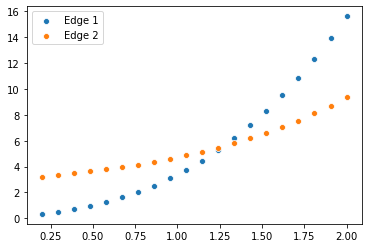

In [48]:
sns.scatterplot(x=x,y=c1, label='Edge 1')
sns.scatterplot(x=x,y=c2, label='Edge 2')
plt.savefig('ex_figs/base_set-up.pdf', dpi=400)

### Generate Training Instances

In [74]:
tr_instances = []

for i in range(len(x)):
    weights = np.array([[1,1]])
    costs = np.array([c1[i], c2[i]])
    
    if costs[0] < costs[1]:
        opt_sol = np.array([1,0])
    else:
        opt_sol = np.array([0,1])
                          
    
    instance = {
        'c': costs,
        'features': np.array([x[i],1]),
        'A': weights,
        'b': 1,
        'var_type': 'integer',
        'objective': 'min',
        'opt_sol': opt_sol,
        'opt_val': min(costs)
    }
    tr_instances.append(instance)


### 1. Least Squares

In [4]:
learning_params = {
    'gradient': 'LS',
    'step_size_fn': 'long_dynamic'
}
learner = SGDLearner(learning_params)
oracle = GurobiSolver()
LSmodel = LinearModel(2, 2)
model_ls = learner.learn(oracle, LSmodel, 
              tr_instances,
              batch_size = len(tr_instances), epochs=50000)

Using license file /Users/connorlawless/gurobi.lic
Academic license - for non-commercial use only
avg train loss 4.282096160702475


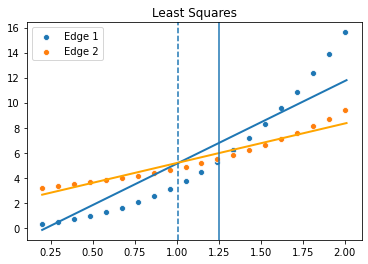

In [65]:
sns.scatterplot(x=x,y=c1, label='Edge 1')
sns.scatterplot(x=x,y=c2, label='Edge 2')
plt.plot([0.2,2.01], 
         [model_ls.model[0] @ np.array([0.2,1]), model_ls.model[0] @ np.array([2.01,1])], 
         linewidth=2)
plt.plot([0.2,2.01], 
         [model_ls.model[1] @ np.array([0.2,1]), model_ls.model[1] @ np.array([2.01,1])], 
         color='orange',
         linewidth=2)
plt.axvline(1.01, ls = '--')
plt.axvline(1.25)

plt.title('Least Squares')
plt.savefig('ex_figs/mse.pdf', dpi=400)

### 2. SPO+

In [51]:
learning_params = {
    'gradient': 'spo_plus',
    'step_size_fn': 'long_dynamic'
}
learner = SGDLearner(learning_params)
oracle = ShortPathOracle()
LSmodel = LinearModel(2, 2)
model_spoplus = learner.learn(oracle, LSmodel, 
              tr_instances,
              batch_size = len(tr_instances), epochs=200000)

avg train loss 0.008786363722425384


In [8]:
model_spoplus.model_avg

array([[ 1.18881393, -1.37705514],
       [-1.18881393,  1.37705514]])

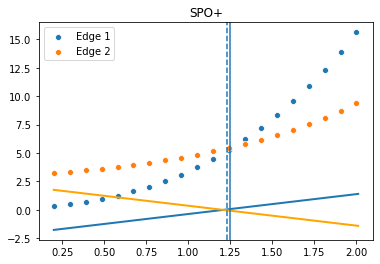

In [66]:
sns.scatterplot(x=x,y=c1, label='Edge 1')
sns.scatterplot(x=x,y=c2, label='Edge 2')
plt.plot([0.2,2.01], 
         [model_spoplus.model[0] @ np.array([0.2,1]), model_spoplus.model[0] @ np.array([2.01,1])], 
         linewidth=2)
plt.plot([0.2,2.01], 
         [model_spoplus.model[1] @ np.array([0.2,1]), model_spoplus.model[1] @ np.array([2.01,1])], 
         color='orange',
         linewidth=2)
plt.axvline(1.23, ls = '--')
plt.axvline(1.25)
plt.title('SPO+')

plt.savefig('ex_figs/spo.pdf', dpi=400)

### Task Loss Reweighting

In [54]:
learning_params = {
    'gradient': 'decision_loss_mse',
    'step_size_fn': 'long_dynamic'
}
learner = SGDLearner(learning_params)
oracle = ShortPathOracle()
LSmodel = LinearModel(2, 2)
model_taskloss = learner.learn(oracle, LSmodel, 
              tr_instances,
              batch_size = len(tr_instances), epochs=200000)

avg train loss 0.0988630533064414


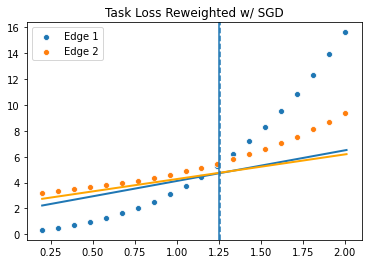

In [67]:
sns.scatterplot(x=x,y=c1, label='Edge 1')
sns.scatterplot(x=x,y=c2, label='Edge 2')
plt.plot([0.2,2.01], 
         [model_taskloss.model[0] @ np.array([0.2,1]), model_taskloss.model_avg[0] @ np.array([2.01,1])], 
         linewidth=2)
plt.plot([0.2,2.01], 
         [model_taskloss.model[1] @ np.array([0.2,1]), model_taskloss.model_avg[1] @ np.array([2.01,1])], 
         color='orange',
         linewidth=2)
plt.axvline(1.26, ls = '--')
plt.axvline(1.25)
plt.title('Task Loss Reweighted w/ SGD')
plt.savefig('ex_figs/task_loss_reweight.pdf', dpi=400)

### Reweighting Effects

In [56]:
def eval_task_loss(instance, model, oracle):
    
    estimated_cost = model.forward(instance['features'])
    oracle.init_model(instance)
    obj, opt_sol = oracle.solve(estimated_cost)
    
    return abs(instance['opt_val'] - instance['c'] @ opt_sol)

oracle = ShortPathOracle()
one_reweight_tr_instances = []
for instance in tr_instances:
    new_instance = instance.copy()
    new_instance['weight'] = eval_task_loss(instance, model_ls, oracle)
    one_reweight_tr_instances.append(new_instance)

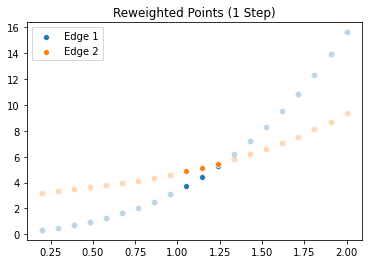

In [68]:
x_reweight = []
c1_reweight = []
c2_reweight = []

for instance in one_reweight_tr_instances:
    if instance['weight'] > 0:
        x_reweight.append(instance['features'][0])
        c1_reweight.append(instance['c'][0])
        c2_reweight.append(instance['c'][1])

sns.scatterplot(x=x,y=c1, alpha = 0.3)
sns.scatterplot(x=x,y=c2, alpha = 0.3)
sns.scatterplot(x=x_reweight,y=c1_reweight, color = sns.color_palette()[0], label='Edge 1')
sns.scatterplot(x=x_reweight,y=c2_reweight,color=sns.color_palette()[1],  label='Edge 2')

plt.title('Reweighted Points (1 Step)')
plt.savefig('ex_figs/weighted_data_points_1.pdf', dpi=400)

In [58]:
tr_instances_filt = [x for x in one_reweight_tr_instances if x['weight'] > 0][0:2]
tr_instances_filt

[{'c': array([3.74287433, 4.86518116]),
  'features': array([1.05263158, 1.        ]),
  'A': array([[1, 1]]),
  'b': 1,
  'var_type': 'integer',
  'objective': 'min',
  'opt_sol': array([1, 0]),
  'opt_val': 3.742874325703455,
  'weight': 1.122306830480233},
 {'c': array([4.47066584, 5.1498928 ]),
  'features': array([1.14736842, 1.        ]),
  'A': array([[1, 1]]),
  'b': 1,
  'var_type': 'integer',
  'objective': 'min',
  'opt_sol': array([1, 0]),
  'opt_val': 4.470665840501531,
  'weight': 0.6792269612000874}]

In [59]:
learning_params = {
    'gradient': 'LS',
    'step_size_fn': 'constant',
    'step_size': 0.001
}
learner = SGDLearner(learning_params)
oracle = GurobiSolver()
LSmodel = LinearModel(2, 2)
model_ls_filt1 = learner.learn(oracle, copy.copy(model_ls), 
              tr_instances_filt,
              batch_size = len(tr_instances_filt), epochs=150000)

avg train loss 4.106770083102493


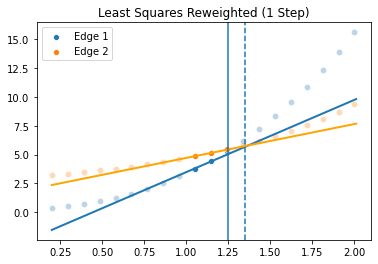

In [69]:
sns.scatterplot(x=x,y=c1, alpha = 0.3)
sns.scatterplot(x=x,y=c2, alpha = 0.3)
sns.scatterplot(x=x_reweight,y=c1_reweight, color = sns.color_palette()[0], label='Edge 1')
sns.scatterplot(x=x_reweight,y=c2_reweight,color=sns.color_palette()[1],  label='Edge 2')

plt.plot([0.2,2.01], 
         [model_ls_filt1.model[0] @ np.array([0.2,1]), model_ls_filt1.model[0] @ np.array([2.01,1])], 
         linewidth=2)
plt.plot([0.2,2.01], 
         [model_ls_filt1.model[1] @ np.array([0.2,1]), model_ls_filt1.model[1] @ np.array([2.01,1])], 
         color='orange',
         linewidth=2)
plt.axvline(1.35, ls = '--')
plt.axvline(1.25)
plt.title('Least Squares Reweighted (1 Step)')
plt.savefig('ex_figs/weighted_mse_1.pdf', dpi=400)

In [61]:
oracle = ShortPathOracle()
two_reweight_tr_instances = []
for instance in tr_instances:
    new_instance = instance.copy()
    new_instance['weight'] = eval_task_loss(instance, model_ls_filt1, oracle)
    two_reweight_tr_instances.append(new_instance)

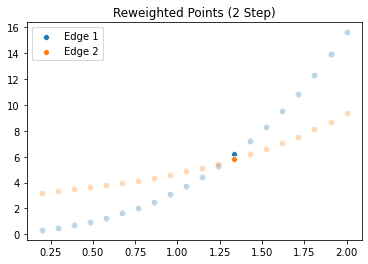

In [72]:
x_reweight = []
c1_reweight = []
c2_reweight = []

for instance in two_reweight_tr_instances:
    if instance['weight'] > 0:
        x_reweight.append(instance['features'][0])
        c1_reweight.append(instance['c'][0])
        c2_reweight.append(instance['c'][1])

sns.scatterplot(x=x,y=c1, alpha = 0.3)
sns.scatterplot(x=x,y=c2, alpha = 0.3)
sns.scatterplot(x=x_reweight,y=c1_reweight, color = sns.color_palette()[0], label='Edge 1')
sns.scatterplot(x=x_reweight,y=c2_reweight,color=sns.color_palette()[1],  label='Edge 2')

plt.title('Reweighted Points (2 Step)')
plt.savefig('ex_figs/weighted_data_points_2.pdf', dpi=400)

In [63]:
tr_instances_filt2 = [x for x in two_reweight_tr_instances if x['weight'] > 0]

learning_params = {
    'gradient': 'LS',
    'step_size_fn': 'constant',
    'step_size': 0.0001
}
learner = SGDLearner(learning_params)
oracle = GurobiSolver()
LSmodel = LinearModel(2, 2)
model_ls_filt2 = learner.learn(oracle, copy.copy(model_ls_filt1), 
              tr_instances_filt2,
              batch_size = len(tr_instances_filt2), epochs=75000)

avg train loss 5.8070023902744206


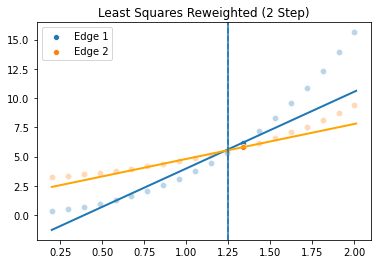

In [73]:
sns.scatterplot(x=x,y=c1, alpha = 0.3)
sns.scatterplot(x=x,y=c2, alpha = 0.3)
sns.scatterplot(x=x_reweight,y=c1_reweight, color = sns.color_palette()[0], label='Edge 1')
sns.scatterplot(x=x_reweight,y=c2_reweight,color=sns.color_palette()[1],  label='Edge 2')

plt.plot([0.2,2.01], 
         [model_ls_filt2.model[0] @ np.array([0.2,1]), model_ls_filt2.model[0] @ np.array([2.01,1])], 
         linewidth=2)
plt.plot([0.2,2.01], 
         [model_ls_filt2.model[1] @ np.array([0.2,1]), model_ls_filt2.model[1] @ np.array([2.01,1])], 
         color='orange',
         linewidth=2)
plt.axvline(1.25, ls = '--')
plt.axvline(1.25)
plt.title('Least Squares Reweighted (2 Step)')
plt.savefig('ex_figs/weighted_mse_2.pdf', dpi=400)